# Set Up

## Importing Libraries

In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [44]:
tf.__version__

'2.15.0'

In [45]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Extra

# Data Collection/Preprocessing

## Collecting Data

In [46]:
data = pd.read_csv("../outputs/training_metadata.csv")

In [47]:
data.head()

,path,left,right,forward,backward,brake
0,outputs/training_data/10.jpeg,0,0,1,0,0
1,outputs/training_data/11.jpeg,0,0,1,0,0
2,outputs/training_data/12.jpeg,0,0,1,0,0
3,outputs/training_data/20.jpeg,0,0,1,0,0
4,outputs/training_data/21.jpeg,0,0,1,0,0


## Analyzing Data

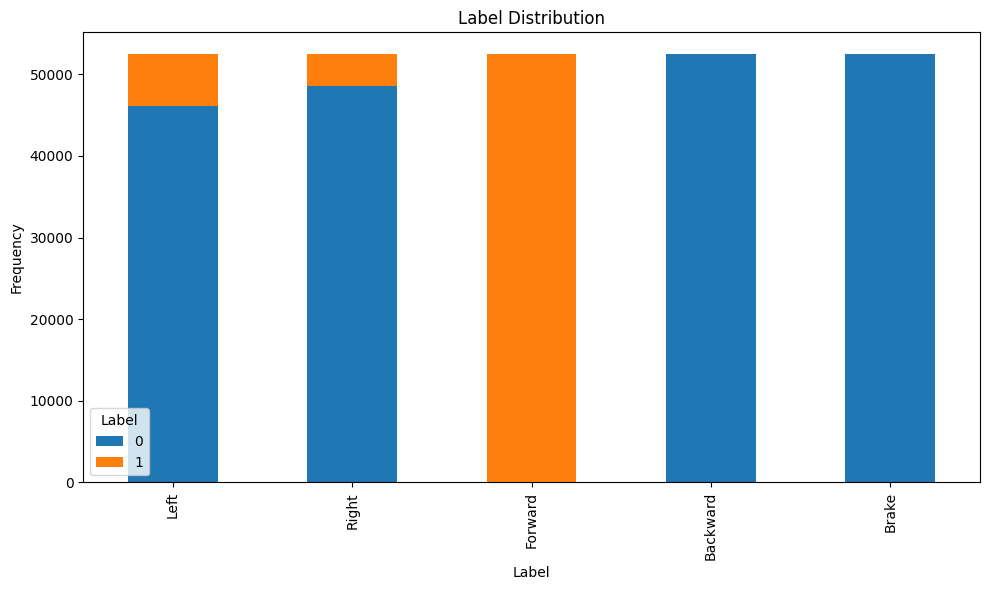

In [48]:
left_labels = data['left']
right_labels = data['right']
forward_labels = data['forward']
backward_labels = data['backward']
brake_labels = data['brake']

left_counts = left_labels.value_counts()
right_counts = right_labels.value_counts()
forward_counts = forward_labels.value_counts()
backward_counts = backward_labels.value_counts()
brake_counts = brake_labels.value_counts()

df = pd.DataFrame({
    'Left': left_counts,
    'Right': right_counts,
    'Forward': forward_counts,
    'Backward': backward_counts,
    'Brake': brake_counts
}).transpose()

# Plot the distribution of labels
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.legend(['0', '1'], title='Label')

plt.tight_layout()
plt.show()

## Preprocessing Data

In [49]:
def load_image(image_path):
    image = Image.open("../"+image_path)
    image = np.array(image)
    return image

In [50]:
data['path'][0]

'outputs/training_data/10.jpeg'

In [51]:
images = [load_image(image_path) for image_path in data['path']]
images = np.array(images)

In [52]:
images[0].shape

(64, 64)

In [53]:
# mean = np.mean(images, axis=(0, 1, 2))
# std = np.std(images, axis=(0, 1, 2))
# scaled_images = (images - mean) / std

In [54]:
targets = data[['left', 'right', 'forward', 'brake']].values

## Splitting Data

In [55]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [56]:
len(X_train)

42014

In [57]:
len(X_test)

5252

# Neural Network

## Model Set Up

In [58]:
optimizer = Adam(learning_rate=0.001)

In [59]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(
        64, 64, 1)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(40, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(4, activation='sigmoid')
])

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 31, 31, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                      

## Training Model

In [61]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [62]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1313/1313 [==============================] - 147s 112ms/step - loss: 0.1410 - binary_accuracy: 0.9464 - val_loss: 0.0842 - val_binary_accuracy: 0.9603
Epoch 2/10
1313/1313 [==============================] - 161s 123ms/step - loss: 0.0934 - binary_accuracy: 0.9583 - val_loss: 0.0757 - val_binary_accuracy: 0.9649
Epoch 3/10
1313/1313 [==============================] - 136s 103ms/step - loss: 0.0786 - binary_accuracy: 0.9648 - val_loss: 0.0649 - val_binary_accuracy: 0.9702
Epoch 4/10
1313/1313 [==============================] - 129s 99ms/step - loss: 0.0668 - binary_accuracy: 0.9704 - val_loss: 0.0578 - val_binary_accuracy: 0.9754
Epoch 5/10
1313/1313 [==============================] - 124s 95ms/step - loss: 0.0544 - binary_accuracy: 0.9769 - val_loss: 0.0485 - val_binary_accuracy: 0.9778
Epoch 6/10
1313/1313 [==============================] - 128s 97ms/step - loss: 0.0456 - binary_accuracy: 0.9815 - val_loss: 0.0365 - val_binary_accuracy: 0.9861
Epoch 7/10
1313/1313 [=========

## Testing Model

In [63]:
test_loss = model.evaluate(X_test, y_test)

165/165 [==============================] - 4s 27ms/step - loss: 0.0223 - binary_accuracy: 0.9919


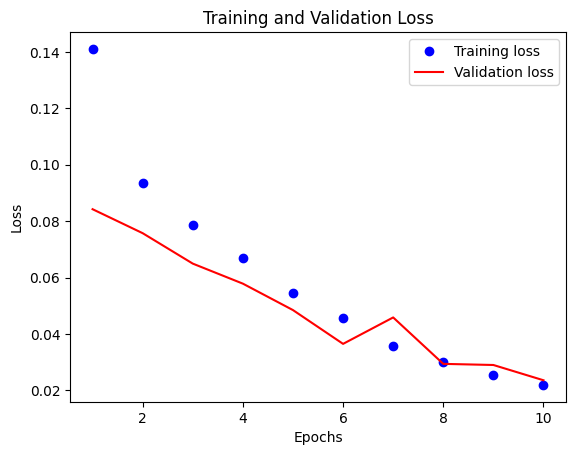

In [64]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

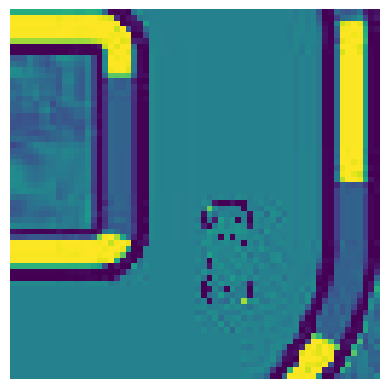

In [71]:
image = X_test[10]
plt.imshow(image)
plt.axis('off')
plt.show()

In [72]:
test_image = image.reshape(1, 64, 64, 1)
predictions = model.predict(test_image)
print(predictions)

1/1 [==============================] - 0s 19ms/step
[[8.1824791e-03 1.0563794e-08 1.0000000e+00 1.1392977e-17]]


## Prediction Distribution

In [67]:
predictions_list = []
for num in range(250):
    image = X_test[num]
    test_image = image.reshape(1, 64, 64, 1)
    prediction = model.predict(test_image)
    predictions_list.append(prediction)

1/1 [==============================] - 0s 11ms/step


In [68]:
predictions_list

[array([[1.9678801e-06, 1.3389283e-02, 1.0000000e+00, 1.1084975e-13]],
       dtype=float32),
 array([[9.8528606e-01, 2.5040630e-09, 1.0000000e+00, 4.0955347e-14]],
       dtype=float32),
 array([[9.9796987e-01, 4.0169689e-07, 1.0000000e+00, 1.3781102e-11]],
       dtype=float32),
 array([[8.7276334e-05, 5.1405532e-06, 1.0000000e+00, 1.1835271e-15]],
       dtype=float32),
 array([[2.1838041e-12, 5.0223076e-07, 1.0000000e+00, 9.1390661e-31]],
       dtype=float32),
 array([[1.1029099e-11, 9.9936908e-01, 1.0000000e+00, 6.1997449e-16]],
       dtype=float32),
 array([[1.1385273e-06, 1.0662061e-06, 1.0000000e+00, 2.8097022e-20]],
       dtype=float32),
 array([[8.0963135e-01, 8.0765833e-10, 1.0000000e+00, 1.1539120e-15]],
       dtype=float32),
 array([[2.3877795e-03, 6.6105148e-09, 1.0000000e+00, 1.9473027e-18]],
       dtype=float32),
 array([[6.091116e-04, 5.018736e-07, 1.000000e+00, 3.117273e-16]],
       dtype=float32),
 array([[8.1824791e-03, 1.0563794e-08, 1.0000000e+00, 1.1392977e

In [69]:
# intermediate_layer_model = tf.keras.Model(inputs=model.input,
#                                                outputs=model.get_layer('conv2d_4').output)
# activations = intermediate_layer_model.predict(test_image.reshape(1, 64, 64, 1))

# print(activations.shape[-1])

# plt.figure(figsize=(10, 10))
# for i in range(activations.shape[-1]):
#     plt.subplot(8, 8, i+1)
#     plt.imshow(activations[0, :, :, i], cmap='viridis')
#     plt.axis('off')
# plt.show()

## Saving Model Weights

In [70]:
model.save("../models/CNN/CNN_steering_model_manual_gs_CMBx4_10epoch_sig_bc.h5")

/Users/andrew/Desktop/Projects/SelfDrivingCarSimulator/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
